# Experiments

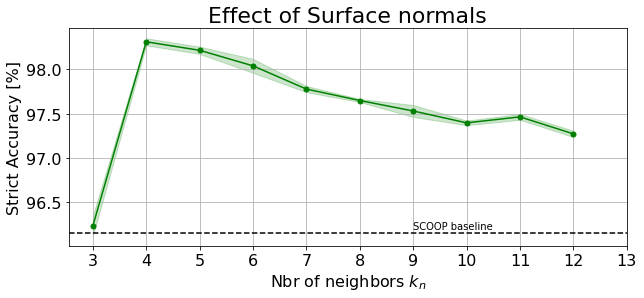

In [3]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from data.PATHS import VIS_PATH
from dev.read_results import load_results_to_df
datasets = ['kitti_t', 'kitti_o', 'argoverse', 'nuscenes', 'waymo']
metric_list = ['EPE3D', 'acc3d_strict', 'acc3d_relax', 'angle_error', 'outlier']

exp_names = ['ablation_normals']
df = load_results_to_df(exp_names)

# metric = "EPE3D"
metric = "acc3d_strict"
our_df = df[(df['model'] == 'SCOOP') & (df['dataset'] == 'kitti_t') & df['forward_weight'] > 0]
base_df = df[(df['model'] == 'SCOOP') & (df['dataset'] == 'kitti_t') & df['forward_weight'] == 0]
# cur_df = df[(df['model'] == 'NeuralPrior') & (df['dataset'] == 'nuscenes')]
plt.close()
plt.plot(base_df['sm_normals_K'], base_df[metric] * 100, 'bo')
plt.plot(our_df['sm_normals_K'], our_df[metric] * 100, 'g*')
plt.title(f"{metric} vs. k_n on KITTIt")
plt.xlabel("k_n")
plt.ylabel(metric)
plt.grid(True)
# plt.savefig(f'{TMP_VIS_PATH}/kittisf.png')

SCOOP_metric = base_df[base_df['sm_normals_K'] == 0][metric].mean() 
multi = 1 if metric == 'EPE3D' else 100

base_met, our_met = [], []
base_error, our_error = [], []
plt.close()
plt.clf()

%matplotlib inline
plt.figure(figsize=(10,4), facecolor=(1, 1, 1))
normals_opt = sorted(base_df['sm_normals_K'].unique())[1:]
for K in normals_opt:
    # base_error = base_df[base_df['sm_normals_K'] == K][metric].std()
    # our_error = our_df[our_df['sm_normals_K'] == K][metric].std()
    
    base_error.append(base_df[base_df['sm_normals_K'] == K][metric].std())
    our_error.append(our_df[our_df['sm_normals_K'] == K][metric].std())
    
    base_met.append(base_df[base_df['sm_normals_K'] == K][metric].mean())
    our_met.append(our_df[our_df['sm_normals_K'] == K][metric].mean())

our_met = np.array(our_met) * multi
base_met = np.array(base_met) * multi
our_error = np.array(our_error) * multi
base_error = np.array(base_error) * multi
SCOOP_metric = SCOOP_metric * multi
# print(base_met)
# print(our_df['sm_normals_K'].unique())
# plt.plot(normals_opt, base_met, 'b-', markersize=10)
# plt.plot(normals_opt, base_met, 'b.', markersize=10)
# plt.plot(normals_opt, our_met, 'g*', markersize=10)
plt.plot(normals_opt, our_met, 'g-', markersize=10)
plt.plot(normals_opt, our_met, 'g.', markersize=10)

plt.fill_between(normals_opt, our_met - our_error, our_met + our_error, color='g', alpha=0.2)
# plt.fill_between(normals_opt, base_met - base_error, base_met + base_error, color='b', alpha=0.2)
plt.axhline(y=SCOOP_metric, color='k', linestyle='dashed')
plt.annotate('SCOOP baseline', xy=(normals_opt[-4], SCOOP_metric + 0.05))

metric_name = 'AS[%]' if metric == 'acc3d_strict' else metric
plt.title("Effect of Surface normals", fontsize=22)
plt.xlabel("Nbr of neighbors $k_n$", fontsize=16)
plt.ylabel('Strict Accuracy [%]', fontsize=16)
# plt.xticks([0,3,5,7,9,11,13])
plt.xticks(list(range(3,14,1)), fontsize=16)
plt.yticks(fontsize=16)
# plt.ylim(0,100)
# plt.yscale('log')
plt.grid(True)
# plt.legend(['ours'])

plt.savefig(f'{TMP_VIS_PATH}/kittit.png')


# df
# cur_df
### Ablations study influence of losses
# exp_names = ['lidar_grid_search', 'grid_search']
# df = load_results_to_df(exp_names)
# 
# 
# hyperparams = ['free_weight', 'smooth_weight', 'forward_weight', 'pc2_smooth', 'sm_normals_K']
# cur_df = df[(df['model'] == 'NeuralPrior') & (df['dataset'] == 'nuscenes')]
# unique_values = {k : sorted(list(set(df[k]))) for k in hyperparams}
# 
# combination = list(itertools.product(*unique_values.values()))
# # print(cur_df)
# for c in combination:
#     config_df = cur_df[(cur_df[hyperparams[0]] == c[0]) & (cur_df[hyperparams[1]] == c[1]) & (cur_df[hyperparams[2]] == c[2]) & (cur_df[hyperparams[3]] == c[3]) &(cur_df[hyperparams[4]] == c[4])]
#     if c[4] not in [0, 5]: continue
#     # if c[3] != 1: continue
#     if c[4] == 5 and c[1] == 0 and c[2] == 0: continue
#     if c[2] == 1: continue
#     if len(config_df) == 0: continue
# 
#     str_print = ''
#     str_print += f'freespace: {c[0]}, smooth_weight: {c[1]}, forward: {c[2]}, pc2_smooth {c[3]}, K_n: {c[4]} '
#     str_print += f'{config_df["EPE3D"].mean():.3f} & {config_df["acc3d_strict"].mean() *100:.2f} & {config_df["acc3d_relax"].mean() * 100:.2f}'
#     print(str_print)
# # base_df

In [85]:
# ITERATIONS OF SCOOP
import os
import glob
import pandas as pd

def load_results_to_df(exp_names : list):

    runs = []

    for exp_name in exp_names:
        exp_dir = f'{os.path.expanduser("~")}/experiments/{exp_name}'
        runs += (sorted(glob.glob(f'{exp_dir}/*')))

    # exp_name = "lidar_grid_search"
    # exp_dir = f'{os.path.expanduser("~")}/experiments/{exp_name}'
    # runs.append(sorted(glob.glob(f'{exp_dir}/*')))

    metric_all = []

    for run in runs:

        if os.path.exists(f'{run}/metric.csv') == False:
            continue

        metric = pd.read_csv(f'{run}/metric.csv', index_col=0, header=None).transpose()
        metric = [v.to_dict() for k,v in metric.iterrows()][0]

        args = pd.read_csv(f'{run}/args.csv', header=None, index_col=0).transpose()
        args = [v.to_dict() for k, v in args.iterrows()][0]

        for k in ['VA', 'free_weight', 'pc2_smooth', 'smooth_weight', 'forward_weight', 'sm_normals_K', 'iters']:
            if k in args.keys():
                args[k] = float(args[k])

        # Skip tryouts
        if args['dev'] == 1:
            continue

        epe = metric['EPE3D']
        avg_solver_time = metric['avg_solver_time']
        # decide about aff
        if args['model'] == 'NeuralPrior':

            if args['VA'] == 0 and args['free_weight'] == 0 and args['forward_weight'] == 0 and args['pc2_smooth'] == 0 and args['smooth_weight'] == 0:
                aff = 'baseline'
            else:
                aff = 'ours'

        if args['model'] == 'SCOOP':
            if args['sm_normals_K'] == 0 and args['VA'] == 0 and args['free_weight'] == 0 and args['forward_weight'] == 0 and args['pc2_smooth'] == 0:
                aff = 'baseline'
            else:
                aff = 'ours'

        # if aff == 'baseline':
        #     continue

        del args['affiliation']
        args['aff'] = aff


        full_dict = {**args, **metric}
        name_weight_list = ['dataset', 'free_weight', 'smooth_weight', 'forward_weight', 'pc2_smooth', 'sm_normals_K', 'VA']
        name_metrics = ['EPE3D', 'acc3d_strict', 'acc3d_relax', 'angle_error', 'outlier']
        interest_dict = {k:v for k,v in full_dict.items() if k in ['aff', 'avg_solver_time', 'model', 'EPE3D', 'iters'] + name_weight_list + name_metrics}

        # metric_all.append(full_dict)
        metric_all.append(interest_dict)

    df = pd.DataFrame(metric_all)

    return df

plt.close()
plt.clf()
fig, ax = plt.subplots(1,2, figsize=(10,5))
df = load_results_to_df(['scoop_iters'])
# df.sort_values(by=['iters'], inplace=True)
x = df['iters']
y = df['EPE3D']
dataset_time = 50 * df['avg_solver_time']

ax[0].plot(x, y, 'o')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('EPE3D')
ax[0].set_title('EPE3D vs. Iterations')
ax[0].grid(True)

ax[1].plot(dataset_time, y, 'o')
ax[1].set_xlabel('Inference Time')
ax[1].set_ylabel('EPE3D')
ax[1].set_title('EPE3D vs. Inference Time')
ax[1].grid(True)

plt.savefig(f'{TMP_VIS_PATH}/scoop_iters.png')


# df[df['iters'] == 30]

,dataset,model,smooth_weight,forward_weight,free_weight,VA,sm_normals_K,pc2_smooth,iters,aff,EPE3D,acc3d_strict,acc3d_relax,angle_error,outlier,avg_solver_time
0,kitti_t,SCOOP,10.0,0.0,0.0,0.0,0.0,0.0,30.0,baseline,0.066956,0.679557,0.902275,0.15039,0.279780,0.522981
13,kitti_t,SCOOP,10.0,0.0,0.0,0.0,0.0,0.0,30.0,baseline,0.066957,0.679546,0.902273,0.15039,0.279780,0.520202
27,kitti_t,SCOOP,10.0,0.0,0.0,0.0,0.0,0.0,30.0,baseline,0.066956,0.679546,0.902273,0.15039,0.279784,0.523162


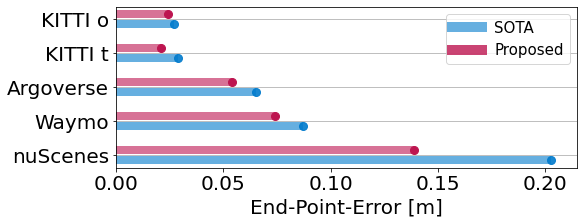

In [18]:
import matplotlib.pyplot as plt
import os 
from data.PATHS import VIS_PATH

epe_dict = {
        'KITTI o_base' : 0.027,
        'KITTI o_ours' : 0.024,
        'KITTI t_base' : 0.029,
       'KITTI t_ours' : 0.021,
       'Argoverse_base' : 0.065,
       'Argoverse_ours' : 0.054,
       'nuScenes_base' : 0.203,
       'nuScenes_ours' : 0.139, 
       'Waymo_base' : 0.087,
       'Waymo_ours' : 0.074,
}

sequence = {'nuScenes' : 0,
            'Waymo' : 1,
            'Argoverse' : 2,
            'KITTI t' : 3,
            'KITTI o' : 4,
            
        
}
# for metric in metric_list:
    
fig, ax = plt.subplots(figsize=(8,3), layout='constrained')
  
multiplier = 0
width = 0.2  # the width of the bars
for k, v in epe_dict.items():
    
    aff = k.split('_')[-1]
    dataset = k.split('_')[0]
    
    x = sequence[dataset]
    
    if aff == 'base':
        # rects = ax.barh(x - width * 0.8, v, width, label=aff, color='blue')    
        ax.hlines(y=x-0.15, xmin=0, xmax=v, color='#007acc', alpha=0.6, linewidth=8)
        ax.plot(v, x-0.15, "o", markersize=8, color='#007acc', alpha=0.9)

    else:
        # rects = ax.barh(x + width * 0.8, v, width, label=aff, color='green')
        ax.hlines(y=x+0.15, xmin=0, xmax=v, color='#BD1550', alpha=0.6, linewidth=8)
        ax.plot(v, x+0.15, "o", markersize=8, color='#BD1550', alpha=1)
    # todo kitti_t with latex
    # ax.bar_label(rects, padding=3)
    # multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    
    # ax.set_title('EPE over Datasets')
    
    
    baseArtist = plt.Line2D((0,1),(0,0), color='#007acc', alpha=0.6, linewidth=10)
    oursArtist = plt.Line2D((0,1),(0,0), color='#BD1550', alpha=0.8, linewidth=10)
    # ax.set_ylim(0, 250)

ax.set_xlabel('End-Point-Error [m]', fontsize=20)    
ax.set_yticks([0,1,2,3,4], sequence.keys(), fontsize=20) # 
ax.set_xlim(0, 0.215)
ax.set_xticks([0,0.05,0.1,0.15,0.2], fontsize=20)
plt.xticks(fontsize=20, rotation=0)

ax.legend([baseArtist, oursArtist], ['SOTA', 'Proposed'], loc='upper right', fontsize=15)
# plt.legend(['baseline','ours'], loc='upper right')
plt.grid(True, axis='y')
# plt.grid(False, axis='x')
plt.savefig(f'{VIS_PATH}/intro_result_bars.png', transparent=True)
# ax.legend(loc='upper left')
    # plt.title(f"Best {metric} over Datasets")
    # plt.xticks(rotation=45)
    # plt.xlabel('Dataset')
    # plt.ylabel(f'Best {metric}')
    
    # plt.savefig(f'{os.path.expanduser("~")}/experiments/plots/intro_result_{metric}.png')
    # plt.close()
    



In [43]:
#TODO parse results from old experiments on KITTISF
datasets = ['kitti_t', 'kitti_o', 'argoverse', 'nuscenes', 'waymo']
metric_list = ['EPE3D', 'acc3d_strict', 'acc3d_relax', 'angle_error', 'outlier']

for dataset in datasets:
    metric_string = ''
    cur_df = df[df['dataset'] == dataset]
    ours_df = cur_df[cur_df['aff'] == 'ours']
    baseline_df = cur_df[cur_df['aff'] == 'baseline']

    for metric in metric_list:
        exp_mask = (df['free_weight'] > 0) & (df['forward_weight'] > 0) & (df['sm_normals_K'] > 0) & (df['smooth_weight'] > 0) & (df['pc2_smooth'] > 0)


# ours_df[exp_mask]
# df[df['dataset'] == 'waymo']
df

,dataset,model,smooth_weight,forward_weight,free_weight,VA,sm_normals_K,pc2_smooth,aff,EPE3D,acc3d_strict,acc3d_relax,angle_error,outlier,avg_solver_time
0,kitti_o,SCOOP,10.0,10.0,1.0,0.0,5.0,1.0,ours,0.024517,0.970476,0.985243,0.125360,0.139567,2.496941
1,kitti_o,SCOOP,10.0,10.0,1.0,0.0,5.0,1.0,ours,0.024513,0.970238,0.985749,0.125569,0.139608,2.530478
2,kitti_o,SCOOP,10.0,10.0,1.0,0.0,5.0,1.0,ours,0.024458,0.970986,0.985509,0.125479,0.139756,2.487313
3,kitti_o,SCOOP,10.0,0.0,0.0,0.0,0.0,0.0,baseline,0.034549,0.920166,0.956980,0.129956,0.169596,1.411158
4,kitti_o,SCOOP,10.0,0.0,0.0,0.0,0.0,0.0,baseline,0.039648,0.880515,0.945679,0.132355,0.184660,1.362737
5,kitti_o,SCOOP,10.0,0.0,0.0,0.0,0.0,0.0,baseline,0.039617,0.880091,0.945635,0.132555,0.184858,1.369793


# RESULTS TO TABLE

In [1]:

from dev.read_results import load_results_to_df
datasets = ['kitti_t', 'kitti_o', 'argoverse', 'nuscenes', 'waymo']
metric_list = ['EPE3D', 'acc3d_strict', 'acc3d_relax', 'angle_error', 'outlier']

exp_names = ['lidar_grid_search', 'grid_search', 'kitti_o_FT']
df = load_results_to_df(exp_names)

mask = (df['aff'] == 'baseline') | (df['smooth_weight'] >= 0) & (df['forward_weight'] >= 0) & (df['pc2_smooth'] >= 0) & (df['sm_normals_K'] >= 0) & (df['VA'] > 0) & (df['free_weight'] >= 0)
# df[mask & (df['dataset'] == 'kitti_t')]
base = (df['aff'] == 'baseline')
sm = (df['smooth_weight'] >= 0) 
fw = (df['forward_weight'] >= 0)
pc2 = (df['pc2_smooth'] >= 0)
norm = (df['sm_normals_K'] >= 0)
va = (df['VA'] > 0)
free = (df['free_weight'] > 0)



# for dataset in datasets:
for dataset in datasets:
    
    dat = df['dataset'] == dataset
    
    for model in ['SCOOP', 'NeuralPrior']:
        # cur_df = cur_df[cur_df['model'] == model]
        mod = (df['model'] == model)
        # ours_df = cur_df[cur_df['aff'] == 'ours']
        
        if dataset in ['argoverse', 'nuscenes', 'waymo'] and model == 'SCOOP': continue
        
        base_tmp_df = df[mod & dat & base] # VA dropped or not?
        
        # print(sm, fw, pc2, norm, va, free, mod, dat)
        for normals_K in df['sm_normals_K'].unique():
            norm_K = (df['sm_normals_K'] == normals_K)
            
            for forward in df['forward_weight'].unique():
                
                for smooth in df['smooth_weight'].unique():
                    for_value = df['forward_weight'] == forward
                    sm_value = df['smooth_weight'] == smooth
                    tmp_df = df[sm_value & fw & pc2 & norm & free & mod & dat & ~base & norm_K & for_value] # VA dropped or not?
                    
                    # NeuralPrior KITTI_t    
                    # tmp_df = df[(df['dataset'] == 'kitti_t') & (df['model'] == 'NeuralPrior') & (df['sm_normals_K'] == 8) &(df['forward_weight'] == 1) & (df['free_weight'] > 0) & (df['pc2_smooth'] > 0) & (df['model'] == 'NeuralPrior') & (df['smooth_weight'] == 0)]
    
                    if len(tmp_df) == 0:
                        continue
                    
                    
                    epe = tmp_df['EPE3D'].mean()   
                    acc = tmp_df['acc3d_strict'].mean() * 100   # in %
                    acc_relax = tmp_df['acc3d_relax'].mean() * 100
                    angle = tmp_df['angle_error'].mean()
                    outlier = tmp_df['outlier'].mean() * 100
                    
                    deviation_epe = tmp_df['EPE3D'].std()
                    deviation_acc = tmp_df['acc3d_strict'].std() * 100  # in %
                    deviation_acc_relax = tmp_df['acc3d_relax'].std() * 100
                    deviation_angle = tmp_df['angle_error'].std()
                    deviation_outlier = tmp_df['outlier'].std() * 100
                    
                    str_print = ''
                    str_print += f"runs: {len(tmp_df)}, "
                    str_print += f"aff: ours, "
                    str_print += f"{dataset}, "
                    str_print += f"{model}, "
                    str_print += f"Smooth: {smooth}, "
                    str_print += f"Forward: {forward}, "
                    str_print += f"Normals_K: {normals_K}, "
                    
                    # metrics with names
                    # str_print += f"EPE3D: {epe:.3f} \pm {deviation_epe:.3f} & "
                    # str_print += f"acc3d_strict: {acc:.3f} \pm {deviation_acc:.3f} & "
                    # str_print += f"acc3d_relax: {acc_relax:.3f} \pm {deviation_acc_relax:.3f} & "
                    # str_print += f"angle_error: {angle:.3f} \pm {deviation_angle:.3f} & "
                    # str_print += f"outlier: {outlier:.3f} \pm {deviation_outlier:.3f}"
                    
                    str_print += f"{epe:.3f} \pm {deviation_epe:.2f} & "
                    str_print += f"{acc:.3f} \pm {deviation_acc:.2f} & "
                    str_print += f"{acc_relax:.3f} \pm {deviation_acc_relax:.2f} & "
                    # str_print += f"{angle:.3f} \pm {deviation_angle:.2f} & "
                    # str_print += f"{outlier:.3f} \pm {deviation_outlier:.2f}"
                    
                    # latex +- is \pm
                    # print(tmp_df)
                    print(str_print)
        
        # print properly
        epe = base_tmp_df['EPE3D'].mean()
        acc = base_tmp_df['acc3d_strict'].mean() * 100   # in %
        acc_relax = base_tmp_df['acc3d_relax'].mean() * 100
        angle = base_tmp_df['angle_error'].mean()
        outlier = base_tmp_df['outlier'].mean() * 100
        
        deviation_epe = base_tmp_df['EPE3D'].std()
        deviation_acc = base_tmp_df['acc3d_strict'].std() * 100  # in %
        deviation_acc_relax = base_tmp_df['acc3d_relax'].std() * 100
        deviation_angle = base_tmp_df['angle_error'].std()
        deviation_outlier = base_tmp_df['outlier'].std() * 100
        
        
        str_print = ''
        str_print += f"runs: {len(base_tmp_df)}, "
        str_print += f"aff: baseline, "
        str_print += f"{dataset}, "
        str_print += f"{model}, "
        
        # metrics with names
        
        str_print += f"{epe:.3f} \pm {deviation_epe:.2f} & "
        str_print += f"{acc:.3f} \pm {deviation_acc:.2f} & "
        str_print += f"{acc_relax:.3f} \pm {deviation_acc_relax:.2f} & "
        # str_print += f"{angle:.3f} \pm {deviation_angle:.2f} & "
        # str_print += f"{outlier:.3f} \pm {deviation_outlier:.2f}"
        
        # latex +- is \pm
        # print(tmp_df)
        print(str_print)
        print("-------")
        # baseline_df = cur_df[cur_df['aff'] == 'baseline']

# ablation do grafu?

runs: 6, aff: ours, kitti_t, SCOOP, Smooth: 10.0, Forward: 0.0, Normals_K: 0.0, 0.026 \pm 0.00 & 97.414 \pm 0.12 & 98.399 \pm 0.08 & 
runs: 12, aff: ours, kitti_t, SCOOP, Smooth: 10.0, Forward: 1.0, Normals_K: 0.0, 0.026 \pm 0.00 & 97.505 \pm 0.10 & 98.432 \pm 0.05 & 
runs: 12, aff: ours, kitti_t, SCOOP, Smooth: 10.0, Forward: 10.0, Normals_K: 0.0, 0.026 \pm 0.00 & 97.508 \pm 0.16 & 98.402 \pm 0.08 & 
runs: 6, aff: ours, kitti_t, SCOOP, Smooth: 10.0, Forward: 0.0, Normals_K: 5.0, 0.024 \pm 0.00 & 98.276 \pm 0.22 & 98.925 \pm 0.16 & 
runs: 12, aff: ours, kitti_t, SCOOP, Smooth: 10.0, Forward: 1.0, Normals_K: 5.0, 0.023 \pm 0.00 & 98.283 \pm 0.19 & 98.928 \pm 0.15 & 
runs: 12, aff: ours, kitti_t, SCOOP, Smooth: 10.0, Forward: 10.0, Normals_K: 5.0, 0.022 \pm 0.00 & 98.613 \pm 0.32 & 99.224 \pm 0.29 & 
runs: 6, aff: ours, kitti_t, SCOOP, Smooth: 10.0, Forward: 0.0, Normals_K: 8.0, 0.024 \pm 0.00 & 98.038 \pm 0.05 & 98.703 \pm 0.02 & 
runs: 12, aff: ours, kitti_t, SCOOP, Smooth: 10.0, Forwa

In [4]:
%%latex


<IPython.core.display.Latex object>

In [ ]:
# plot figure 1 bar
import matplotlib.pyplot as plt
# runs: 6, aff: ours, kitti_t, SCOOP, forward: 10.0, normals_K: 5.0, 0.021 \pm 0.00 & 98.887 \pm 0.02 & 99.484 \pm 0.03 & 0.113 \pm 0.00 & 11.310 \pm 0.01
# runs: 9, aff: ours, kitti_o, SCOOP, forward: 10.0, normals_K: 5.0, 0.024 \pm 0.00 & 97.773 \pm 0.56 & 98.862 \pm 0.25 & 0.113 \pm 0.01 & 13.329 \pm 0.48
# runs: 6, aff: ours, argoverse, NeuralPrior, forward: 10.0, normals_K: 5.0, 0.054 \pm 0.00 & 81.108 \pm 0.26 & 92.513 \pm 0.10 & 0.223 \pm 0.00 & 29.750 \pm 0.13
# runs: 6, aff: ours, waymo, NeuralPrior, forward: 10.0, normals_K: 5.0, 0.074 \pm 0.00 & 81.649 \pm 0.21 & 91.446 \pm 0.13 & 0.290 \pm 0.01 & 35.366 \pm 0.17
# runs: 6, aff: ours, nuscenes, NeuralPrior, forward: 10.0, normals_K: 5.0, 0.139 \pm 0.00 & 55.563 \pm 0.22 & 80.430 \pm 0.16 & 0.220 \pm 0.01 & 40.427 \pm 0.23



# SCOOP kitti_t  0.029 95.87 97.98 12.17
# runs: 6, aff: baseline, kitti_o, SCOOP, 0.034 \pm 0.00 & 92.898 \pm 4.14 & 96.312 \pm 1.56 & 0.120 \pm 0.01 & 15.941 \pm 2.29
# runs: 6, aff: baseline, argoverse, NeuralPrior, 0.065 \pm 0.00 & 77.894 \pm 0.21 & 90.676 \pm 0.14 & 0.226 \pm 0.00 & 32.141 \pm 0.11
# runs: 6, aff: baseline, waymo, NeuralPrior, 0.087 \pm 0.00 & 78.960 \pm 0.18 & 89.958 \pm 0.10 & 0.299 \pm 0.00 & 37.422 \pm 0.10
# runs: 6, aff: baseline, nuscenes, NeuralPrior, 0.203 \pm 0.00 & 49.638 \pm 0.24 & 76.033 \pm 0.28 & 0.244 \pm 0.00 & 44.861 \pm 0.18


base_epe = [0.029, 0.034, 0.065, 0.087, 0.203]
ours_epe = [0.021, 0.024, 0.054, 0.074, 0.139]

base_acc = [95.87, 92.898, 77.894, 78.960, 49.638]
ours_acc = [98.887, 97.773, 81.108, 81.649, 55.563]




In [57]:
import itertools
import pandas as pd
import os
from configs.models import SCOOP_cfg, NeuralPrior_cfg
### Make configs

permute_cfg = {'model': ['NeuralPrior', 'SCOOP'],
               'store_inference' : [0],
               'sm_normals_K': [0, 5, 8, 12],
               'forward_weight':  [0, 1, 10],
               'pc2_smooth': [0, 1],
               'K': [4, 32],
               'smooth_weight' : [0, 1],
               'free_weight': [0, 1],
               'VA': [0, 1],
               'lr': [0.2, 0.008],
               'dataset': ['nuscenes'],
               # 'dataset': ['argoverse', 'nuscenes', 'waymo'],
               'max_radius' : [2],
               'early_patience' : [50],
               }

permute_kitti_our = {'model': ['SCOOP'],
               'store_inference' : [0],
               'sm_normals_K': [0,3,4,5,6,7,8,9,10,11,12],
               'forward_weight':  [10],
               'pc2_smooth': [1],
               'K': [32],
               'smooth_weight' : [10],
               'free_weight': [1],
               'VA': [0],
               'lr': [0.2],
               'dataset': ['kitti_t'],
               # 'dataset': ['argoverse', 'nuscenes', 'waymo'],
               'max_radius' : [2],
               'early_patience' : [150],
                'iters' : [150],
               }

permute_kitti_base = {'model': ['SCOOP'],
               'store_inference' : [0],
               'sm_normals_K': [0,3,4,5,6,7,8,9,10,11,12],
               'forward_weight':  [0],
               'pc2_smooth': [0],
               'K': [32],
               'smooth_weight' : [0],
               'free_weight': [0],
               'VA': [0],
               'lr': [0.2],
               'dataset': ['kitti_t'],
               # 'dataset': ['argoverse', 'nuscenes', 'waymo'],
               'max_radius' : [2],
               'early_patience' : [150],
                'iters' : [150],
               }

permute_nuscenes = {'model': ['NeuralPrior'],
               'store_inference' : [0],
               'sm_normals_K': [5],
               'forward_weight':  [10],
               'pc2_smooth': [1],
               'K': [4,32],
               'smooth_weight' : [0,1],
               'free_weight': [0.01,0.05,0.1],
               'VA': [0],
               'lr': [0.2, 0.003],
               'dataset': ['nuscenes'],
               # 'dataset': ['argoverse', 'nuscenes', 'waymo'],
               'max_radius' : [2],
               'early_patience' : [30],
                'iters' : [250],
               }

permute_kitti_iters = {'model': ['SCOOP'],
               'store_inference' : [0],
               'sm_normals_K': [0],
               'forward_weight':  [0],
               'pc2_smooth': [0],
               'K': [32],
               'smooth_weight' : [10],
               'free_weight': [0],
               'VA': [0],
               'lr': [0.2],
               'dataset': ['kitti_t'],
               # 'dataset': ['argoverse', 'nuscenes', 'waymo'],
               'max_radius' : [2],
               'early_patience' : [150],
                'iters' : list(range(20, 150, 10)),
               }

kitti_ablation_normals = {'model': ['SCOOP'],
               'store_inference' : [1],
               'sm_normals_K': [0],
               'forward_weight':  [0],
               'pc2_smooth': [0],
               'K': [32],
               'smooth_weight' : [10],
               'free_weight': [0],
               'VA': [0],
               'lr': [0.2],
               'dataset': ['kitti_t'],
               # 'dataset': ['argoverse', 'nuscenes', 'waymo'],
               'max_radius' : [20],
               'early_patience' : [150],
                'iters' : [150],
               }
# 'dataset': ['kitti_t', 'kitti_o', 'argoverse', 'nuscenes', 'waymo'],   # wait for lidar on tommorow
# permute all possible combinations of variables above



def create_experiment_configs(init_cfg):
    
# index = permute_kitti_iters.keys()
index = kitti_ablation_normals.keys()
combinations1 = list(itertools.product(*kitti_ablation_normals.values()))
# combinations2 = list(itertools.product(*permute_kitti_base.values()))
# combinations = combinations1 + combinations2
combinations = combinations1

df = pd.DataFrame(combinations, columns=index)

valid_cfg_list = []


# leave out some configs
runs = 1

for run in range(runs):

    for i in range(len(combinations)):
        default_cfg = {}
        c = df.iloc[i]

        ##### KittiSF
        if c['dataset'].startswith('kitti'):

            if c['K'] != 32: continue

        ##### Lidar
        if not c['dataset'].startswith('kitti'):

            if c['K'] > 8: continue
            if c['sm_normals_K'] > 5: continue

        if c['dataset'] in ['argoverse', 'nuscenes', 'waymo'] and c['sm_normals_K'] > 5: continue

        ##### Models
        if c['model'] == "SCOOP":
            default_cfg = SCOOP_cfg
            if c['K'] != 32: continue
            if c['lr'] != 0.2: continue
            if c['dataset'] in ['argoverse', 'nuscenes', 'waymo']: continue
            # if c['smooth_weight'] != 10: continue

        if c['model'] == 'NeuralPrior':
            default_cfg = NeuralPrior_cfg
            # if c['dataset'] in ['kitti_o']: continue
            if c['lr'] == 0.2: continue
            # if c['lr'] != 0.001 and c['dataset'] == 'kitti_t': continue
            # if c['lr'] != 0.003 and c['dataset'] in ['argoverse', 'waymo', 'nuscenes']: continue


        ##### General
        if c['forward_weight'] == 0 and c['pc2_smooth'] == 1: continue
        if c['K'] == 0 and (c['forward_weight'] > 0 or c['VA'] > 0): continue


        final_config = {**default_cfg, **c.to_dict()}
        final_config['exp_name'] = final_config['model']
        final_config['dev'] = 0

        # Exceptions
        if c['model'] == "SCOOP":
            final_config['smooth_weight'] = 10 #default_cfg['smooth_weight']
            # final_config['iters'] = 150

        if c['model'] == "NeuralPrior":
            final_config['iters'] = 250

        if c['dataset'] == 'nuscenes':
            final_config['early_patience'] = 30
        # Just to make them more and compute multiple times. Otherwise it is not in argparser
        valid_cfg_list.append(final_config)

print(len(valid_cfg_list))
nbr_gpu = 5
experiment_time = 10 / 60 # hours
gpu_time = len(valid_cfg_list) * experiment_time

print(f"Runs: {len(valid_cfg_list)} ---> GPU time: {gpu_time:.1f} hours ---> {gpu_time / nbr_gpu / 24:.1f} days")

final_df = pd.DataFrame(valid_cfg_list, columns=index)
# save to different formats
final_df.to_csv(f'{os.path.expanduser("~")}/pcflow/configs/experiments/normals_0.csv', index=False)


1
Runs: 1 ---> GPU time: 0.2 hours ---> 0.0 days


In [6]:
import itertools
import pandas as pd
import os
from configs.models import SCOOP_cfg, NeuralPrior_cfg
### Make configs

ours_nsf = {'model': ['NeuralPrior'],
               'store_inference' : [0],
               'sm_normals_K': [5],
               'forward_weight':  [10],
               'pc2_smooth': [1],
               'K': [4, 32],
               'smooth_weight' : [1],
               'free_weight': [0],
               'VA': [0],
               'lr': [0.008],
               # 'dataset': ['nuscenes'],
               'dataset': ['argoverse', 'nuscenes', 'waymo', 'kitti_t', 'kitti_o'],
               'max_radius' : [2],
               'early_patience' : [50],
               }

base_nsf = {'model': ['NeuralPrior'],
               'store_inference' : [0],
               'sm_normals_K': [0],
               'forward_weight':  [0],
               'pc2_smooth': [0],
               'K': [0],
               'smooth_weight' : [0],
               'free_weight': [0],
               'VA': [0],
               'lr': [0.008],
               'dataset': ['argoverse', 'nuscenes', 'waymo', 'kitti_t', 'kitti_o'],
               'max_radius' : [2],
               'early_patience' : [50],
               }

ours_scoop = {'model': ['SCOOP'],
               'store_inference' : [0],
               'sm_normals_K': [4],
               'forward_weight':  [10],
               'pc2_smooth': [1],
               'K': [32],
               'smooth_weight' : [10],
               'free_weight': [0],
               'VA': [0],
               'lr': [0.2],
               'dataset': ['kitti_t', 'kitti_o'],
               'max_radius' : [2],
               'early_patience' : [150],
               }

base_scoop = {'model': ['SCOOP'],
               'store_inference' : [0],
               'sm_normals_K': [0],
               'forward_weight':  [0],
               'pc2_smooth': [0],
               'K': [32],
               'smooth_weight' : [10],
               'free_weight': [0],
               'VA': [0],
               'lr': [0.2],
               'dataset': ['kitti_t', 'kitti_o'],
               'max_radius' : [20],
               'early_patience' : [150],
               }

def create_experiment_configs(init_dict, path, runs=1):
    
    # index = permute_kitti_iters.keys()
    index = init_dict.keys()
    combinations1 = list(itertools.product(*init_dict.values()))
    # combinations2 = list(itertools.product(*permute_kitti_base.values()))
    # combinations = combinations1 + combinations2
    combinations = combinations1
    
    df = pd.DataFrame(combinations, columns=index)
    
    valid_cfg_list = []
    
    for run in range(runs):
    
        for i in range(len(combinations)):
            default_cfg = {}
            c = df.iloc[i]
    
            ##### KittiSF
            if c['dataset'].startswith('kitti'):
    
                if c['K'] != 32 and c['model'] == 'SCOOP': continue
                
    
            ##### Lidar
            if not c['dataset'].startswith('kitti'):
    
                if c['K'] > 8: continue
                if c['sm_normals_K'] > 5: continue
    
            if c['dataset'] in ['argoverse', 'nuscenes', 'waymo'] and c['sm_normals_K'] > 5: continue
    
            ##### Models
            if c['model'] == "SCOOP":
                default_cfg = SCOOP_cfg
                if c['K'] != 32: continue
                if c['lr'] != 0.2: continue
                if c['dataset'] in ['argoverse', 'nuscenes', 'waymo']: continue
                # if c['smooth_weight'] != 10: continue
    
            if c['model'] == 'NeuralPrior':
                default_cfg = NeuralPrior_cfg
                # if c['dataset'] in ['kitti_o']: continue
                if c['lr'] == 0.2: continue
                # if c['lr'] != 0.001 and c['dataset'] == 'kitti_t': continue
                # if c['lr'] != 0.003 and c['dataset'] in ['argoverse', 'waymo', 'nuscenes']: continue
    
    
            ##### General
            if c['forward_weight'] == 0 and c['pc2_smooth'] == 1: continue
            if c['K'] == 0 and (c['forward_weight'] > 0 or c['VA'] > 0): continue
    
    
            final_config = {**default_cfg, **c.to_dict()}
            final_config['exp_name'] = final_config['model']
            final_config['dev'] = 0
    
            # Exceptions
            if c['model'] == "SCOOP":
                final_config['smooth_weight'] = 10 #default_cfg['smooth_weight']
                # final_config['iters'] = 150
    
            if c['model'] == "NeuralPrior":
                final_config['iters'] = 250
    
            if c['dataset'] == 'nuscenes':
                final_config['early_patience'] = 30
            # Just to make them more and compute multiple times. Otherwise it is not in argparser
            valid_cfg_list.append(final_config)
    
    
    final_df = pd.DataFrame(valid_cfg_list, columns=index)
    # save to different formats
    final_df.to_csv(f'{os.path.expanduser("~")}/pcflow/configs/experiments/{path}', index=False)

create_experiment_configs(ours_nsf, 'ours_nfs.csv', runs=1)
create_experiment_configs(base_nsf, 'base_nfs.csv', runs=1)
create_experiment_configs(ours_scoop, 'ours_scoop.csv', runs=1)
create_experiment_configs(base_scoop, 'base_scoop.csv', runs=1)


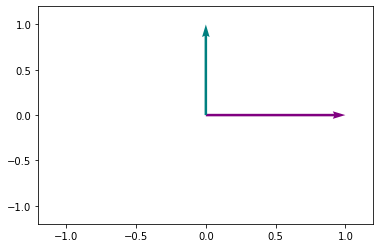

In [25]:
import matplotlib.pyplot as plt

plt.quiver(0,0, 1,0, color='purple', alpha=1, scale=1, angles='xy', scale_units='xy')
plt.quiver(0,0, 0,1, color='teal', alpha=1, scale=1, angles='xy', scale_units='xy')
# plt.axis('equal')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)

plt.show()